# DFT-322 NEES values analysis

This analysis has been performed because very high NEES values appeared in the PE output

See http://jiraprod1.delphiauto.net:8080/browse/DFT-322 for details.

Root cause has been found in `_extract_variances_and_covariances` method in `F360MudpObjectsBuilderV15`, `F360MudpObjectsBuilderV13`, `F360MudpInternalObjectsBuilderV14`, `F360MudpInternalObjectsBuilderV12`.

Consider this enum definition:
```
F360_TRK_FLTR_CTCA_STATE_X = 0, /* WCS position x. */ (xposn)
F360_TRK_FLTR_CTCA_STATE_Y = 1, /* WCS position y. */ (yposn)
F360_TRK_FLTR_CTCA_STATE_H = 2, /* WCS velocity heading. */ (heading)
F360_TRK_FLTR_CTCA_STATE_C = 3, /* WCS curvature. */ (curvature)
F360_TRK_FLTR_CTCA_STATE_S = 4, /* WCS speed. */ (speed)
F360_TRK_FLTR_CTCA_STATE_A = 5 /* WCS tangential acceleration (heading alignment). */ (tang_accel)
```

Note that heading is at index 2 and speed is at index 4.

However in the `_extract_variances_and_covariances` method the indices have been mistakenly swapped.

This happened most likely because (speed, heading) pair is analogous to (r, $\varphi$).

Since speed is the first pair element, it has probably been assumed to have the lower index than heading (i.e. 2 instead of 4).

Obviously this led to incorrect calculation of NEES values.

After applying the fix, NEES values means for TPs decreased to the acceptable levels around 1 or 2 (depending on the number of dimensions).

See http://jiraprod1.delphiauto.net:8080/browse/DFT-348 for comparision.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
from scipy.stats import chi2
import aspe.extractors
import AptivPerformanceEvaluation

### Log path
\\\\10.224.186.68\\AD-Shared\\ASPE\\Logs\\Examples\\ASPE_Examples\\F360_RT_Range\\RCTA\\rRf360t4060306v204p50_2_12\\FTP402_TC4_TT_155253_001_rRf360t4060306v204p50_2_12.mudp &rarr; PEPipeline &rarr; pairs_est.pkl, pairs_est_ref.pkl

Note: `dev_position_x` and `dev_position_y` are calculated using `PositionDeviationR2R`, not the default `PositionDeviationC2C`.

In [10]:
pairs_est = pd.read_pickle('pairs_est.pkl')
pairs_est

,scan_index,timestamp,slot_id,unique_id,id,id_split_merge,position_x,position_y,position_variance_x,position_variance_y,position_covariance,velocity_otg_x,velocity_otg_y,velocity_otg_variance_x,velocity_otg_variance_y,velocity_otg_covariance,acceleration_otg_x,acceleration_otg_y,acceleration_otg_variance_x,acceleration_otg_variance_y,acceleration_otg_covariance,bounding_box_dimensions_x,bounding_box_dimensions_y,bounding_box_orientation,bounding_box_refpoint_lat_offset_ratio,bounding_box_refpoint_long_offset_ratio,bounding_box_pseudo_variance_lat_shift_left,bounding_box_pseudo_variance_lat_shift_right,bounding_box_pseudo_variance_long_shift_front,bounding_box_pseudo_variance_long_shift_rear,bounding_box_pseudo_variance_orientation_local,movement_status,motion_model_type,motion_model_state_suppl,motion_model_variances_suppl,motion_model_covariances_suppl,object_class,object_class_probability,existence_indicator,sensor_confirmation,ticks_since_created,ticks_since_last_detected,ticks_since_state_updated,track_property_flags_ghost,track_property_flags_reflection,track_property_flags_split_merge,speed,center_x,center_y,filter_type,tracker_id,status,yaw_rate,curvature,confidence_level,n_dets,f_moving,f_moveable,f360_object_class,wid1,f_reliable_pseudo_msmt,f_fast_moving,xvel,probability_truck,init_scheme,f_oncoming,probability_motorcycle,probability_undet,heading,yaccel,f_crossing,num_reduced_dets,probability_car,yposn,probability_pedestrian,time_since_track_updated,time_since_cluster_created,vcs_heading,yvel,xposn,f_onguardrail,wid2,xaccel,time_since_stage_start,probability_bicycle,accuracy_width,slow_moving,f_vehicular_trk,time_since_measurement,len1,tang_accel,pointing,len2,accuracy_length,index_est
0,5,4189.741757,0,0,1,NaN,-3.848145,53.878540,0.462783,0.446460,0.000378,0.027366,-0.362774,0.120170,0.099435,0.001689,0.057845,-0.738420,NaN,NaN,NaN,1.479570,1.118091,0.000000,0.105618,0.614077,NaN,NaN,NaN,NaN,NaN,MovementStatus.STATIONARY,1,"[-3.8481452465057373, 0.027365637943148613, 0....","[0.4627827, 0.12016951, 3.0992908, 0.44646046,...","[0.00037799674, 0.0016892655, 0.007955531]",0,0.800000,0.999385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.363805,-4.016931,54.319496,F360ObjectsFilterType.CCA,1,4,0.000000,0.000000,0.445102,1,0,0,0,0.118091,0,0,0.027366,4.563098e-10,8,0,0.010041,0.8,0.000000,-0.738420,0,1,0.000007,53.878540,1.799111e-01,0.0,0.150000,0.000000,-0.362774,-3.848145,0,1.000000,0.057845,0.100000,0.010041,1.716266,0,0,0.127243,0.908570,0.000000,0.000000,0.571000,4.923387,0
1,6,4189.791786,0,0,1,NaN,-3.980891,53.952801,0.316953,0.309071,0.000194,0.044706,-0.595285,0.158091,0.117605,0.003554,0.107787,-1.349927,NaN,NaN,NaN,1.813025,1.241973,0.000000,0.194830,0.687545,NaN,NaN,NaN,NaN,NaN,MovementStatus.STATIONARY,1,"[-3.9808905124664307, 0.04470646381378174, 0.1...","[0.3169534, 0.15809079, 3.1472182, 0.30907083,...","[0.00019446274, 0.0035538836, 0.022222988]",0,0.700000,0.999394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.596962,-4.320914,54.331814,F360ObjectsFilterType.CCA,1,4,0.000000,0.000000,0.545725,3,0,0,0,0.241973,1,0,0.044706,5.353332e-09,8,0,0.018251,0.7,0.000000,-1.349927,0,1,0.000060,53.952801,2.634379e-01,0.0,0.200000,0.000000,-0.595285,-3.980891,0,1.000000,0.107787,0.150000,0.018251,1.722145,0,0,0.127214,1.246536,0.000000,0.000000,0.566489,4.555954,1
2,7,4189.841741,0,0,1,NaN,-4.116448,53.883400,0.241623,0.287758,0.000177,0.057956,-0.877390,0.211478,0.139190,0.006286,0.142417,-2.029557,NaN,NaN,NaN,1.799436,1.000000,0.000000,0.376405,0.687756,NaN,NaN,NaN,NaN,NaN,MovementStatus.STATIONARY,1,"[-4.116448402404785, 0.05795598775148392, 0.14...","[0.24162269, 0.21147841, 3.1938808, 0.2877576,...","[0.00017742548, 0.006285728, 0.040634535]",0,0.600000,0.999393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.879302,-4.454303,54.006996,F360ObjectsFilterType.CCA,1,4,0.000000,0.000000,0.624090,3,0,0,0,0.376405,0,0,0.057956,6.792381e-09,8,0,0.024471,0.6,0.000000,-2.029557,0,1,0.000077,53.883400,3.509816e-01,0.0,0.250000,0.000000,-0.877390,-4.116448,0,0.623595,0

In [11]:
pairs_est_ref = pd.read_pickle('pairs_est_ref.pkl')
pairs_est_ref

,scan_index,timestamp,slot_id,unique_id,index_ref,index_est,unique_id_ref,unique_id_est,association_distance,is_associated,binary_classification,relevancy_flag_ref,relevancy_flag_est,dev_position_x,dev_position_y,dev_speed,dev_orientation,dev_velocity_x,dev_velocity_y,nees_value_position_x,nees_value_position_y,nees_value_position_xy,nees_value_velocity_x,nees_value_velocity_y,nees_value_velocity_xy,log_index
0,5,4189.741757,NaN,NaN,2,0,0,0,0.604878,False,BCType.NotAssigned,True,False,1.32318,-1.10938,-2.191738,2.225120,-1.47487,-1.74329,3.78322,2.75661,6.5452,18.1016,30.5632,47.9493,0
1,6,4189.791786,NaN,NaN,3,1,0,0,0.428042,False,BCType.NotAssigned,True,False,1.31605,-0.58301,-2.456452,2.226342,-2.12032,-1.64418,5.46453,1.09975,6.56733,28.4377,22.9864,50.1254,0
2,7,4189.841741,NaN,NaN,4,2,0,0,0.636060,False,BCType.NotAssigned,True,False,0.983738,-0.315172,-2.011777,2.226691,-1.78275,-1.44283,4.00517,0.345197,4.35196,15.0284,14.9562,28.925,0
3,8,4189.891745,NaN,NaN,5,3,0,0,0.632610,False,BCType.NotAssigned,True,False,1.13384,-0.0369171,-1.788297,2.225993,-1.81632,-1.23442,6.55408,0.0050547,6.55951,11.7821,9.50561,20.2026,0
4,9,4189.941675,NaN,NaN,6,4,0,0,0.593797,True,BCType.TruePositive,True,True,1.1593,0.0129773,-1.666351,2.224073,-1.98374,-1.04379,7.06772,0.000662876,7.06816,10.7841,6.12869,15.8721,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,209,4199.941649,NaN,NaN,206,2333,0,15,0.551058,True,BCType.TruePositive,True,True,-0.554687,0.177215,-0.151882,0.377249,0.809778,-2.56559,0.499885,0.0526346,0.553956,1.8076,2.63563,2.97651,0
209,210,4199.991858,NaN,NaN,207,2334,0,15,0.534687,True,BCType.TruePositive,True,True,-0.55306,0.129874,-0.012738,0.396201,0.719461,-2.4328,0.224719,0.0137751,0.241403,0.907536,2.22514,2.38864,0
210,211,4200.041665,NaN,NaN,208,2335,0,15,0.545419,True,BCType.TruePositive,True,True,-0.573044,-0.0471316,0.066883,0.407638,0.669133,-2.49483,0.467854,0.00328313,0.470808,1.1694,2.27097,2.37047,0
211,212,4200.091776,NaN,NaN,209,2336,0,15,0.485339,True,BCType.TruePositive,True,True,-0.521944,0.0400682,0.102005,0.416371,0.652511,-2.499,0.433269,0.00262315,0.436059,1.12616,2.16646,2.31054,0


In [12]:
assert len(pairs_est) == len(pairs_est_ref)
n = len(pairs_est)
print(n)

213


## Verification of NEES values calculation (DFT-306)
NEES values were calculated in a optimized way using np.matmul (@) on 3D numpy arrays.

Let's check the values by performing calculations for each row individually.

### Definitions
$ \text{Mahalanobis distance} = \sqrt{ \text{NEES value} } $

$ \text{NEES values} = \text{deviation} \cdot \text{covariance matrix} \cdot \text{deviation}^T $&emsp;(assuming that deviation is a horizontal vector)

$ \text{NEES value 1D} = \dfrac{ \text{deviation}^2 }{ \text{variance} } $

https://en.wikipedia.org/wiki/Mahalanobis_distance#Definition_and_properties

In [13]:
for i in range(n):
    # read signals from pairs_est
    position_variance_x = pairs_est.loc[i, 'position_variance_x']
    position_variance_y = pairs_est.loc[i, 'position_variance_y']
    position_covariance = pairs_est.loc[i, 'position_covariance']
    velocity_otg_variance_x = pairs_est.loc[i, 'velocity_otg_variance_x']
    velocity_otg_variance_y = pairs_est.loc[i, 'velocity_otg_variance_y']
    velocity_otg_covariance = pairs_est.loc[i, 'velocity_otg_covariance']

    # read signals from pairs_est_ref
    dev_position_x = pairs_est_ref.loc[i, 'dev_position_x']
    dev_position_y = pairs_est_ref.loc[i, 'dev_position_y']
    dev_velocity_x = pairs_est_ref.loc[i, 'dev_velocity_x']
    dev_velocity_y = pairs_est_ref.loc[i, 'dev_velocity_y']
    nees_value_position_x = pairs_est_ref.loc[i, 'nees_value_position_x']
    nees_value_position_y = pairs_est_ref.loc[i, 'nees_value_position_y']
    nees_value_position_xy = pairs_est_ref.loc[i, 'nees_value_position_xy']
    nees_value_velocity_x = pairs_est_ref.loc[i, 'nees_value_velocity_x']
    nees_value_velocity_y = pairs_est_ref.loc[i, 'nees_value_velocity_y']
    nees_value_velocity_xy = pairs_est_ref.loc[i, 'nees_value_velocity_xy']

    # verify position NEES values 1D
    assert nees_value_position_x == dev_position_x**2 / position_variance_x
    assert nees_value_position_y == dev_position_y**2 / position_variance_y

    # verify position NEES value 2D
    assert nees_value_position_xy == \
        np.array([dev_position_x, dev_position_y]) @ \
        np.linalg.pinv(np.array([
            [position_variance_x, position_covariance],
            [position_covariance, position_variance_y]
        ])) @ \
        np.array([dev_position_x, dev_position_y]).T

    # verify velocity NEES values 1D
    assert nees_value_velocity_x == dev_velocity_x**2 / velocity_otg_variance_x
    assert nees_value_velocity_y == dev_velocity_y**2 / velocity_otg_variance_y

    # verify velocity NEES value 2D
    assert nees_value_velocity_xy == \
        np.array([dev_velocity_x, dev_velocity_y]) @ \
        np.linalg.pinv(np.array([
            [velocity_otg_variance_x, velocity_otg_covariance],
            [velocity_otg_covariance, velocity_otg_variance_y]
        ])) @ \
        np.array([dev_velocity_x, dev_velocity_y]).T

print('OK')

OK


Note: if this fails, please make sure that position deviations are `R2R`, not `C2C`.

Conclusion: NEES values are calculated properly.

### Prepare joined dataframe for analysis

In [14]:
joined_df = pairs_est_ref.join(pairs_est, rsuffix='_est')
joined_df.head()

,scan_index,timestamp,slot_id,unique_id,index_ref,index_est,unique_id_ref,unique_id_est,association_distance,is_associated,binary_classification,relevancy_flag_ref,relevancy_flag_est,dev_position_x,dev_position_y,dev_speed,dev_orientation,dev_velocity_x,dev_velocity_y,nees_value_position_x,nees_value_position_y,nees_value_position_xy,nees_value_velocity_x,nees_value_velocity_y,nees_value_velocity_xy,log_index,scan_index_est,timestamp_est,slot_id_est,unique_id_est,id,id_split_merge,position_x,position_y,position_variance_x,position_variance_y,position_covariance,velocity_otg_x,velocity_otg_y,velocity_otg_variance_x,velocity_otg_variance_y,velocity_otg_covariance,acceleration_otg_x,acceleration_otg_y,acceleration_otg_variance_x,acceleration_otg_variance_y,acceleration_otg_covariance,bounding_box_dimensions_x,bounding_box_dimensions_y,bounding_box_orientation,bounding_box_refpoint_lat_offset_ratio,bounding_box_refpoint_long_offset_ratio,bounding_box_pseudo_variance_lat_shift_left,bounding_box_pseudo_variance_lat_shift_right,bounding_box_pseudo_variance_long_shift_front,bounding_box_pseudo_variance_long_shift_rear,bounding_box_pseudo_variance_orientation_local,movement_status,motion_model_type,motion_model_state_suppl,motion_model_variances_suppl,motion_model_covariances_suppl,object_class,object_class_probability,existence_indicator,sensor_confirmation,ticks_since_created,ticks_since_last_detected,ticks_since_state_updated,track_property_flags_ghost,track_property_flags_reflection,track_property_flags_split_merge,speed,center_x,center_y,filter_type,tracker_id,status,yaw_rate,curvature,confidence_level,n_dets,f_moving,f_moveable,f360_object_class,wid1,f_reliable_pseudo_msmt,f_fast_moving,xvel,probability_truck,init_scheme,f_oncoming,probability_motorcycle,probability_undet,heading,yaccel,f_crossing,num_reduced_dets,probability_car,yposn,probability_pedestrian,time_since_track_updated,time_since_cluster_created,vcs_heading,yvel,xposn,f_onguardrail,wid2,xaccel,time_since_stage_start,probability_bicycle,accuracy_width,slow_moving,f_vehicular_trk,time_since_measurement,len1,tang_accel,pointing,len2,accuracy_length,index_est_est
0,5,4189.741757,NaN,NaN,2,0,0,0,0.604878,False,BCType.NotAssigned,True,False,1.32318,-1.10938,-2.191738,2.225120,-1.47487,-1.74329,3.78322,2.75661,6.5452,18.1016,30.5632,47.9493,0,5,4189.741757,0,0,1,NaN,-3.848145,53.878540,0.462783,0.446460,0.000378,0.027366,-0.362774,0.120170,0.099435,0.001689,0.057845,-0.738420,NaN,NaN,NaN,1.479570,1.118091,0.0,0.105618,0.614077,NaN,NaN,NaN,NaN,NaN,MovementStatus.STATIONARY,1,"[-3.8481452465057373, 0.027365637943148613, 0....","[0.4627827, 0.12016951, 3.0992908, 0.44646046,...","[0.00037799674, 0.0016892655, 0.007955531]",0,0.8,0.999385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.363805,-4.016931,54.319496,F360ObjectsFilterType.CCA,1,4,0.0,0.0,0.445102,1,0,0,0,0.118091,0,0,0.027366,4.563098e-10,8,0,0.010041,0.8,0.0,-0.738420,0,1,0.000007,53.878540,0.179911,0.0,0.15,0.0,-0.362774,-3.848145,0,1.000000,0.057845,0.10,0.010041,1.716266,0,0,0.127243,0.908570,0.0,0.0,0.571000,4.923387,0
1,6,4189.791786,NaN,NaN,3,1,0,0,0.428042,False,BCType.NotAssigned,True,False,1.31605,-0.58301,-2.456452,2.226342,-2.12032,-1.64418,5.46453,1.09975,6.56733,28.4377,22.9864,50.1254,0,6,4189.791786,0,0,1,NaN,-3.980891,53.952801,0.316953,0.309071,0.000194,0.044706,-0.595285,0.158091,0.117605,0.003554,0.107787,-1.349927,NaN,NaN,NaN,1.813025,1.241973,0.0,0.194830,0.687545,NaN,NaN,NaN,NaN,NaN,MovementStatus.STATIONARY,1,"[-3.9808905124664307, 0.04470646381378174, 0.1...","[0.3169534, 0.15809079, 3.1472182, 0.30907083,...","[0.00019446274, 0.0035538836, 0.022222988]",0,0.7,0.999394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.596962,-4.320914,54.331814,F360ObjectsFilterType.CCA,1,4,0.0,0.0,0.545725,3,0,0,0,0.241973,1,0,0.044706,5.353332e-09,8,0,0.018251,0.7,0.0,-1.349927,0,1,0.000060,53.952801,0.263438,0.0,0.20,0.0,-0.595285,-3.980891,0,1.000000,0.107787,0.15,0.018251,1.722145,0,0,0.127214,1.246536,0.0,0.0,0.566489,4.555954,1
2,7,4189.

In [15]:
from aspe.extractors.F360.Enums.f360_objects import F360ObjectsFilterType
joined_df_cca = joined_df[joined_df['motion_model_type'] == F360ObjectsFilterType.CCA.value]
joined_df_ctca = joined_df[joined_df['motion_model_type'] == F360ObjectsFilterType.CTCA.value]

In [16]:
len(joined_df_cca), len(joined_df_ctca)

(9, 204)

## Position NEES values analysis

In [17]:
joined_df.sort_values('nees_value_position_x', ascending=False).head()

,scan_index,timestamp,slot_id,unique_id,index_ref,index_est,unique_id_ref,unique_id_est,association_distance,is_associated,binary_classification,relevancy_flag_ref,relevancy_flag_est,dev_position_x,dev_position_y,dev_speed,dev_orientation,dev_velocity_x,dev_velocity_y,nees_value_position_x,nees_value_position_y,nees_value_position_xy,nees_value_velocity_x,nees_value_velocity_y,nees_value_velocity_xy,log_index,scan_index_est,timestamp_est,slot_id_est,unique_id_est,id,id_split_merge,position_x,position_y,position_variance_x,position_variance_y,position_covariance,velocity_otg_x,velocity_otg_y,velocity_otg_variance_x,velocity_otg_variance_y,velocity_otg_covariance,acceleration_otg_x,acceleration_otg_y,acceleration_otg_variance_x,acceleration_otg_variance_y,acceleration_otg_covariance,bounding_box_dimensions_x,bounding_box_dimensions_y,bounding_box_orientation,bounding_box_refpoint_lat_offset_ratio,bounding_box_refpoint_long_offset_ratio,bounding_box_pseudo_variance_lat_shift_left,bounding_box_pseudo_variance_lat_shift_right,bounding_box_pseudo_variance_long_shift_front,bounding_box_pseudo_variance_long_shift_rear,bounding_box_pseudo_variance_orientation_local,movement_status,motion_model_type,motion_model_state_suppl,motion_model_variances_suppl,motion_model_covariances_suppl,object_class,object_class_probability,existence_indicator,sensor_confirmation,ticks_since_created,ticks_since_last_detected,ticks_since_state_updated,track_property_flags_ghost,track_property_flags_reflection,track_property_flags_split_merge,speed,center_x,center_y,filter_type,tracker_id,status,yaw_rate,curvature,confidence_level,n_dets,f_moving,f_moveable,f360_object_class,wid1,f_reliable_pseudo_msmt,f_fast_moving,xvel,probability_truck,init_scheme,f_oncoming,probability_motorcycle,probability_undet,heading,yaccel,f_crossing,num_reduced_dets,probability_car,yposn,probability_pedestrian,time_since_track_updated,time_since_cluster_created,vcs_heading,yvel,xposn,f_onguardrail,wid2,xaccel,time_since_stage_start,probability_bicycle,accuracy_width,slow_moving,f_vehicular_trk,time_since_measurement,len1,tang_accel,pointing,len2,accuracy_length,index_est_est
11,13,4190.141675,NaN,NaN,10,8,0,0,0.853144,True,BCType.TruePositive,True,True,1.51897,0.196774,-1.166289,0.689878,-1.55334,-0.850931,9.82864,0.13954,9.94525,2.76255,1.53034,4.06656,0,13,4190.141675,0,0,1,NaN,-4.201733,53.348186,0.234750,0.277483,0.002613,0.133901,-2.141967,0.873419,0.473151,0.037550,0.208644,-3.188971,NaN,NaN,NaN,2.000000,1.186209,-1.508365,0.413283,0.753995,NaN,NaN,NaN,NaN,NaN,MovementStatus.MOVING,1,"[-4.201732635498047, 0.1339007467031479, 0.208...","[0.2347498, 0.8734186, 3.4814963, 0.2774835, 0...","[0.0026125617, 0.037550155, 0.09765981]",4,0.822259,0.021763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.146148,-4.130762,53.861603,F360ObjectsFilterType.CCA,1,5,0.0,0.0,0.346080,0,1,1,4,0.49024,0,0,0.133901,6.426166e-08,8,0,0.088505,0.0,-1.508365,-3.188971,0,0,0.000730,53.348186,0.822259,0.20,0.55,-1.508365,-2.141967,-4.201733,0,0.695969,0.208644,0.15,0.088505,1.510868,0,0,0.327325,1.507990,0.0,-1.508365,0.492010,3.896473,8
9,12,4190.091675,NaN,NaN,9,7,0,0,0.762599,True,BCType.TruePositive,True,True,1.43303,0.155581,-1.275309,0.698022,-1.62859,-0.911109,9.45852,0.0902497,9.53576,3.67966,2.17551,5.53241,0,12,4190.091675,0,0,1,NaN,-4.208167,53.451298,0.217112,0.268204,0.001765,0.123469,-1.982518,0.720805,0.381575,0.031798,0.208644,-3.188971,NaN,NaN,NaN,2.000000,1.186209,-1.508598,0.413283,0.753995,NaN,NaN,NaN,NaN,NaN,MovementStatus.MOVING,1,"[-4.20816707611084, 0.12346852570772171, 0.208...","[0.21711233, 0.7208051, 3.4314964, 0.26820362,...","[0.0017647599, 0.03179782, 0.09765981]",4,0.746131,0.217020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.986359,-4.137077,53.964699,F360ObjectsFilterType.CCA,1,5,0.0,0.0,0.444376,0,1,1,4,0.49024,0,0,0.123469,5.279174e-08,8,0,0.076634,0.1,-1.508598,-3.188971,0,0,0.000601,53.451298,0.746131,0.15,0.50,-1.508598,-1.982518,-4.208167,0,0.695969,0.208644,0.10,0.076634,1.459757,0,0,0.277325,

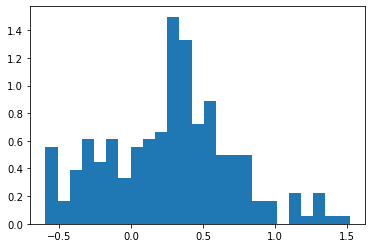

In [18]:
_ = plt.hist(joined_df['dev_position_x'], bins=25, density=True)

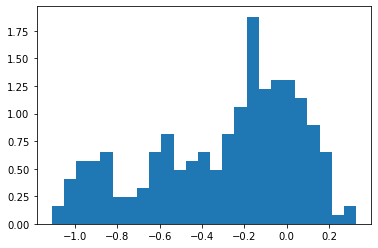

In [19]:
_ = plt.hist(joined_df['dev_position_y'], bins=25, density=True)

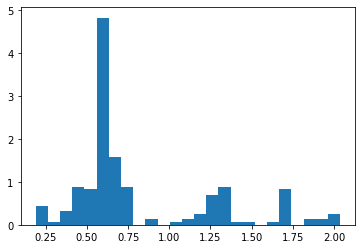

In [20]:
_ = plt.hist(joined_df['position_variance_x'], bins=25, density=True)

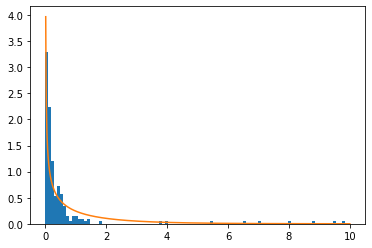

In [21]:
plt.hist(joined_df['nees_value_position_x'], bins=100, density=True)
xs = np.linspace(0, 10, 1000)
ys = chi2.pdf(xs, df=1)
plt.plot(xs, ys)

In [22]:
joined_df['nees_value_position_x'].mean()

0.5589636733179649

In [23]:
sum(joined_df['nees_value_position_x'] <= 1) / len(joined_df)

0.9061032863849765

(0.2886943108180143, 0.8967136150234741)

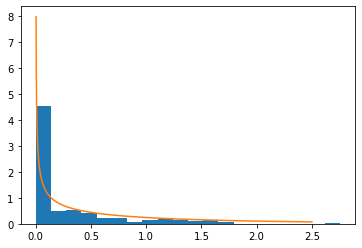

In [24]:
plt.hist(joined_df['nees_value_position_y'], bins=20, density=True)
xs = np.linspace(0, 2.5, 1000)
ys = chi2.pdf(xs, df=1)
plt.plot(xs, ys)
joined_df['nees_value_position_y'].mean(), sum(joined_df['nees_value_position_y'] <= 1) / len(joined_df)

(0.8494514362686014, 0.9530516431924883)

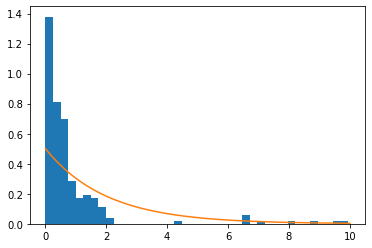

In [25]:
plt.hist(joined_df['nees_value_position_xy'], bins=40, density=True)
xs = np.linspace(0, 10, 1000)
ys = chi2.pdf(xs, df=2)
plt.plot(xs, ys)
joined_df['nees_value_position_xy'].mean(), sum(joined_df['nees_value_position_xy'] <= 2) / len(joined_df)

## Velocity NEES values analysis

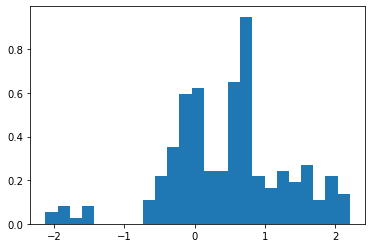

In [26]:
_ = plt.hist(joined_df['dev_velocity_x'], bins=25, density=True)

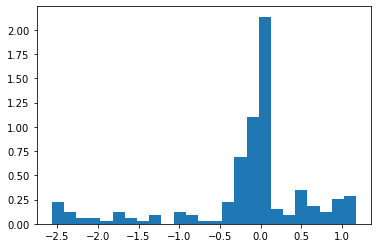

In [27]:
_ = plt.hist(joined_df['dev_velocity_y'], bins=25, density=True)

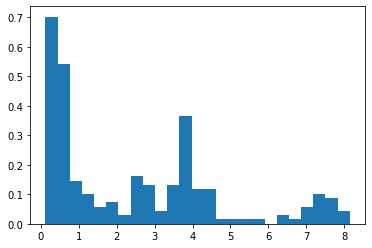

In [28]:
_ = plt.hist(joined_df['velocity_otg_variance_x'], bins=25, density=True)

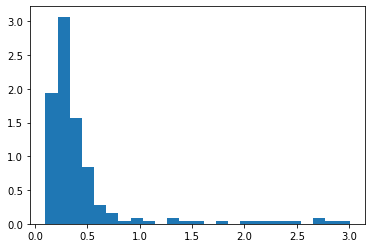

In [29]:
_ = plt.hist(joined_df['velocity_otg_variance_y'], bins=25, density=True)

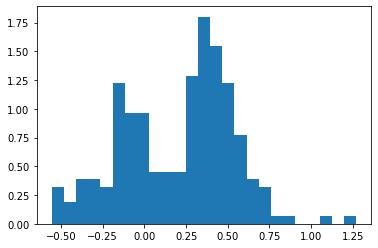

In [30]:
_ = plt.hist(joined_df['velocity_otg_covariance'], bins=25, density=True)

(1.417973841182345, 0.704225352112676)

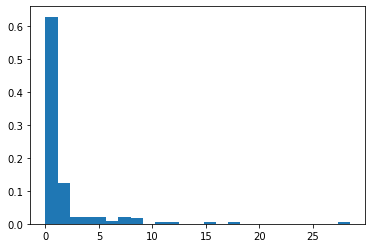

In [31]:
_ = plt.hist(joined_df['nees_value_velocity_x'], bins=25, density=True)
joined_df['nees_value_velocity_x'].mean(), sum(joined_df['nees_value_velocity_x'] <= 1) / len(joined_df)

(1.5002291805002614, 0.6666666666666666)

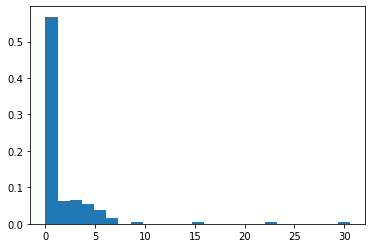

In [32]:
_ = plt.hist(joined_df['nees_value_velocity_y'], bins=25, density=True)
joined_df['nees_value_velocity_y'].mean(), sum(joined_df['nees_value_velocity_y'] <= 1) / len(joined_df)

(3.081227505496855, 0.5446009389671361)

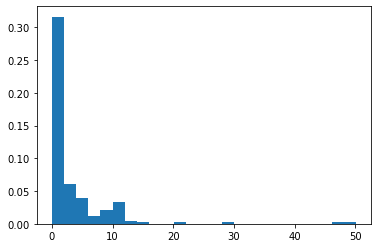

In [33]:
_ = plt.hist(joined_df['nees_value_velocity_xy'], bins=25, density=True)
joined_df['nees_value_velocity_xy'].mean(), sum(joined_df['nees_value_velocity_xy'] <= 1) / len(joined_df)

## Outliers

In [35]:
mask = joined_df['nees_value_position_xy'] > 2
columns = ['position_variance_x', 'position_variance_y', 'position_covariance',
           'dev_position_x', 'dev_position_y', 'motion_model_type',
           'nees_value_position_x', 'nees_value_position_y', 'nees_value_position_xy']

joined_df[columns][mask]

,position_variance_x,position_variance_y,position_covariance,dev_position_x,dev_position_y,motion_model_type,nees_value_position_x,nees_value_position_y,nees_value_position_xy
0,0.462783,0.446460,0.000378,1.32318,-1.10938,1,3.78322,2.75661,6.5452
1,0.316953,0.309071,0.000194,1.31605,-0.58301,1,5.46453,1.09975,6.56733
2,0.241623,0.287758,0.000177,0.983738,-0.315172,1,4.00517,0.345197,4.35196
3,0.196150,0.269625,0.000229,1.13384,-0.0369171,1,6.55408,0.0050547,6.55951
4,0.190159,0.254058,0.000398,1.1593,0.0129773,1,7.06772,0.000662876,7.06816
5,0.195769,0.257044,0.000695,1.24989,0.0638636,1,7.97996,0.0158672,7.9937
7,0.204458,0.261589,0.001139,1.34241,0.111082,1,8.81388,0.0471705,8.85492
9,0.217112,0.268204,0.001765,1.43303,0.155581,1,9.45852,0.0902497,9.53576
11,0.234750,0.277483,0.002613,1.51897,0.196774,1,9.82864,0.13954,9.94525
82,0.735064,0.703723,0.001700,0.827688,-0.91472,2,0.931983,1.18898,2.12595


In [36]:
mask = joined_df['nees_value_velocity_xy'] > 2
columns = ['velocity_otg_variance_x', 'velocity_otg_variance_y', 'velocity_otg_covariance',
           'dev_velocity_x', 'dev_velocity_y', 'motion_model_type',
           'nees_value_velocity_x', 'nees_value_velocity_y', 'nees_value_velocity_xy']

joined_df[columns][mask]

,velocity_otg_variance_x,velocity_otg_variance_y,velocity_otg_covariance,dev_velocity_x,dev_velocity_y,motion_model_type,nees_value_velocity_x,nees_value_velocity_y,nees_value_velocity_xy
0,0.120170,0.099435,0.001689,-1.47487,-1.74329,1,18.1016,30.5632,47.9493
1,0.158091,0.117605,0.003554,-2.12032,-1.64418,1,28.4377,22.9864,50.1254
2,0.211478,0.139190,0.006286,-1.78275,-1.44283,1,15.0284,14.9562,28.925
3,0.280002,0.160304,0.011453,-1.81632,-1.23442,1,11.7821,9.50561,20.2026
4,0.364910,0.177769,0.017471,-1.98374,-1.04379,1,10.7841,6.12869,15.8721
...,...,...,...,...,...,...,...,...,...
208,0.362769,2.497419,-0.496125,0.809778,-2.56559,2,1.8076,2.63563,2.97651
209,0.570362,2.659839,-0.479006,0.719461,-2.4328,2,0.907536,2.22514,2.38864
210,0.382878,2.740766,-0.554844,0.669133,-2.49483,2,1.1694,2.27097,2.37047
211,0.378072,2.882574,-0.519094,0.652511,-2.499,2,1.12616,2.16646,2.31054
